##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# American Option Pricing in TFF under the Black-Scholes Model

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/American_Option_Black_Scholes.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/American_Option_Black_Scholes.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [0]:
#@title Install TF Quant Finance
!pip install tf-quant-finance

In [0]:
#@title Install QuantLib
!pip install QuantLib-Python

### This notebook demonstrates the use of low level Tensorflow Quant Finance tools for American Option pricing under the Black-Scholes model with emphasis on the following aspects:

  * **Batching**: Tensorflow is vectorized out of the box. Tensorflow Finance (TFF) written to leverage this wherever possible.
    * Most methods accept a "batch" of inputs.
  * **Hardware Accelerators**: Tensorflow supports GPUs without any significant code changes. Significant speedups with no code change.
    * Write the model once and run it on CPU or GPU.


In [0]:
#@title Imports { display-mode: "form" }

import matplotlib.pyplot as plt
import numpy as np
import time

import pandas as pd
import seaborn as sns

import tensorflow as tf

 # tff for Tensorflow Finance
import tf_quant_finance as tff 

grids = tff.math.pde.grids
pde_tools = tff.math.pde

from IPython.core.pylabtools import figsize
figsize(21, 14) # better graph size for Colab  

import warnings
warnings.filterwarnings("ignore",
                        category=FutureWarning)  # suppress printing warnings


 ### Setup American Option pricer
   American option price $V(x, t)$ of an option with spot price $x$ at time $t$
   under Black-Scholes model satisfies the following PDE
   $$V_{t} + \frac{\sigma^2}{2}  x^2  V_{xx} + r  x  V_{x}
   - r  V(t, x) = 0.$$

  Tensorflow Quant Finance library provides tools for solving Parabolic PDE's
  of the form  
  $$V_{t} + \frac{a(t, x)}{2}  V_{xx} + b(t, x) V_{x} - c(t, x)  V = 0$$

  Henceforth,
  $a(t, x)$, $b(t, x)$, and $c(t, x)$ are referred to as quadratic, linear and
  shift coefficients, respectively. We describe in details how to write a
  custom pricer that is both batchable (i.e., multiple equations can be solved
  simultaneously) and compatible with an NVIDIA GPU. 


In [0]:
#@title American Option pricer

# tf.function decorator makes the function faster if the graph mode.
# Autograph is disabled in order to depracate the warnings
@tf.function(autograph=False)
def american_option(number_of_options,
                    num_grid_points,
                    time_delta,
                    strike,
                    volatility,
                    risk_free_rate,
                    expiry,
                    dtype=np.float64,
                    scheme="crank_nicolson_scheme"):
  """Computes American Call options prices.

  Args:
    number_of_options: A Python int. Number of options to price.
    number_grid_points: A Python int. Number of grid points for the finite
      difference scheme.
    time_delta: A Python float. Grid time discretization parameter.
    strike: A real `Tensor` of shape `[number_of_options, number_grid_points]`.
      Represents the strikes of the underlying American options. 
    volatility: A real `Tensor` of shape `[number_of_options]`.
      Represents the volatilities of the underlying American options. 
    risk_free_rate: A real `Tensor` of shape `[number_of_options]`.
      Represents the risk-free interest rates associated with the underlying
      American options.
    expiry: A Python float. Expiry date of the options. If the options
      have different expiries, volatility term has to adjusted to
      make expiries the same.
    scheme: Finite difference scheme to use for pricing. An instance of
      `tff.math.pde.time_marching_schemes`. Defaults to the Crank-Nicolson
      scheme.
    dtype: Optional `tf.dtype` used to assert dtype of the input `Tensor`s.

  Returns:
    A tuple of the estimated option prices of shape
    `[number_of_options, number_grid_points]` and the corresponding `Tensor` of
    grid locations of shape `[number_grid_points]`.
  """

  # Upper bound for the grid spacial grid
  s_max = 300.
  # Lower bound for the grid spacial grid
  s_min = 1.
  grid = grids.uniform_grid(minimums=[s_min], maximums=[s_max],
                            sizes=[number_grid_points],
                            dtype=dtype)    
  # volatility^2 * x^2. 
  def quadratic_coeff_fn(t, x):
    return tf.square(volatility) * tf.square(x)

  # risk_free_rate * x. 
  def linear_coeff_fn(t, x):
    return risk_free_rate * x

  # risk_free_rate. 
  def shift_coeff_fn(t, x):
    del x
    return risk_free_rate

  # Set up boundary functions
  def lower_boundary_fn(t):
    del t
    return tf.zeros([number_of_options], dtype=dtype)

  def upper_boundary_fn(t):
    return tf.reshape(s_max - strike * tf.exp(-risk_free_rate * (expiry - t)),
                      [number_of_options])

  # Set time step. Note that if using explicit scheme, time step
  # needs to be very small.
  def time_step_fn(state):
    del state
    return tf.constant(time_delta, dtype=dtype)

  # In order to price American option one needs to set option values to 
  # V(x) := max(V(x), max(x - strike, 0)) after each iteration
  
  def value_transform_fn(state):
    x = state.coordinate_grid.locations[0]
    v_star = tf.nn.relu(x - strike)
    return tf.maximum(state.value_grid, v_star)
    
  solver_kernel = pde_tools.ParabolicDifferentialEquationSolver( 
      quadratic_coeff_fn,
      lower_boundary_fn,
      upper_boundary_fn,
      linear_coeff_fn, shift_coeff_fn,
      time_marching_scheme=pde_tools.time_marching_schemes.__getattribute__(
          scheme)())

  def payoff_fn(state):
    option_bound = tf.nn.relu(
        state.coordinate_grid.locations[0] - strike)
    # Broadcast to the shape of value dimension, if necessary.
    option_bound = option_bound + tf.zeros_like(state.value_grid)
    return option_bound

  # Set up grid stepper, that moves approximate solution from time `t` to
  # a solution at time `t - time_delta`
  bgs = pde_tools.BackwardGridStepper(
      expiry, solver_kernel.one_step, grid,
      time_step_fn=time_step_fn,
      value_dim=number_of_options,
      dtype=dtype)
  bgs.transform_values(payoff_fn)
  bgs.step_back_to_time(0.0, value_transform_fn)
  # Estimate European call option price
  estimate = bgs.state()
  return estimate.value_grid, estimate.coordinate_grid.locations[0]

# Function to generate volatilities, rates, strikes
def option_param(number_of_options, dtype, seed=42):
  np.random.seed(seed)
  if number_of_options > 1:
    volatility = tf.random.uniform(shape=(number_of_options, 1),
                                   dtype=dtype) * 0.1 + 0.3
    # Random risk free rate between 0 and 0.2.
    risk_free_rate = tf.constant(
        np.random.rand(number_of_options, 1) * 0.05, dtype)
    # Random strike between 20 and 120.
    strike = tf.constant(
        np.random.rand(number_of_options, 1) * 100 + 50, dtype)
  else:
    volatility = tf.constant([0.3], dtype)
    # Random risk free rate between 0 and 0.2.
    risk_free_rate = tf.constant([0.05], dtype)
    # Random strike between 20 and 120.
    strike = tf.constant([50], dtype)    
  return volatility, risk_free_rate, strike

### Batching

* Batching is a powerful feature of design of Tensorflow.
* TFF leverages this strongly.
* Most methods can accept a "batch" of inputs.
* Example below (Batch of American Call Options with varying strikes, vols and rates).



In [0]:
#@title Price multiple American Call options at a time

tf.reset_default_graph()

number_of_options = 10 #@param

time_delta = 0.005


expiry = 1.0  

number_grid_points = 1024 

dtype = np.float64 

spot = 110  + tf.random.uniform(shape=[number_of_options, 1], dtype=dtype)

# Generate volatilities, rates, strikes
volatility, risk_free_rate, strike = option_param(number_of_options, dtype)

# Build a graph to compute prices of the American Options.
estimate, grid_locations = american_option(
    number_of_options=number_of_options,
    time_delta=time_delta,
    expiry=expiry,
    num_grid_points=number_grid_points,
    volatility=volatility,
    risk_free_rate=risk_free_rate,
    strike=strike,
    dtype=dtype)

with tf.Session() as sess:
  estimate, grid_locations = sess.run([estimate, grid_locations])

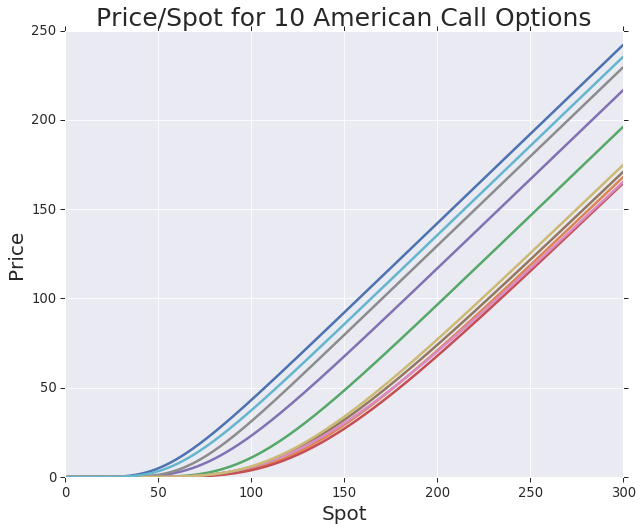

In [0]:
#@title Price/spot plot for the American Call options
# Prepare data for plotting 
import itertools
options = map(str, range(1, 11))
options_obs = list(itertools.chain.from_iterable(
    itertools.repeat(x, grid_locations.shape[0]) for x in options))
plot_data = pd.DataFrame({
    'Spot': list(np.ndarray.flatten(grid_locations)) * number_of_options, 
    'Price': np.ndarray.flatten(estimate),
    'Option': options_obs})


# Prepare Plotting 
plt.figure(figsize=(10, 8))
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
plot = sns.lineplot(x="Spot", y="Price", hue="Option",
                    data=plot_data,
                    palette=sns.color_palette()[:number_of_options],
                    legend=False)
plot.axes.set_title("Price/Spot for 10 American Call Options",fontsize=25)
xlabel = plot.axes.get_xlabel()
ylabel = plot.axes.get_ylabel()
plot.axes.set_xlabel(xlabel, fontsize=20)
plot.axes.set_ylabel(ylabel, fontsize=20)
plt.show()

### Speedup from batching

* Price of 5000 American Call options. Time comparison with QuantLib

In [0]:
#@title Tensorflow Finance pricing

number_of_options = 5000  #@param

time_delta = 0.005

expiry = 1.0 

number_grid_points = 1024

dtype = np.float64

tf.reset_default_graph()

# Generate volatilities, rates, strikes
volatility, risk_free_rate, strike = option_param(number_of_options, dtype)

## TFF on GPU
device = "/gpu:0"
with tf.device(device):
  estimate, _ = american_option(
      number_of_options=number_of_options,
      time_delta=time_delta,
      expiry=expiry,
      num_grid_points=number_grid_points, 
      volatility=volatility,
      risk_free_rate=risk_free_rate,
      strike=strike,
      dtype=dtype)

with tf.Session() as sess:
  sess.run(tf.constant([0]))  # warming-up

with tf.Session() as sess:
  t = time.time()
  estimate = sess.run(estimate)
time_gpu = time.time() - t
print('------------------------')
print('Tensorflow GPU')
print('wall time: ', time_gpu)
print('options per second: ', number_of_options / time_gpu)
print('------------------------')

## TFF on CPU
tf.reset_default_graph()

# Generate volatilities, rates, strikes
volatility, risk_free_rate, strike = option_param(number_of_options, dtype)

device = "/cpu:0"
with tf.device(device):
  estimate, _ = american_option(
      number_of_options=number_of_options,
      time_delta=time_delta,
      expiry=expiry,
      num_grid_points=number_grid_points,
      volatility=volatility,
      risk_free_rate=risk_free_rate,
      strike=strike,
      dtype=dtype)

with tf.Session() as sess:
  sess.run(tf.constant([0]))  # warming-up

with tf.Session() as sess:
  t = time.time()
  estimate = sess.run(estimate)
time_cpu = time.time() - t
print('Tensorflow CPU')
print('wall time: ', time_cpu)
print('options per second: ', number_of_options / time_cpu)
print('------------------------')



------------------------
Tensorflow GPU
('wall time: ', 2.4413340091705322)
('options per second: ', 2048.0606017931977)
------------------------
Tensorflow CPU
('wall time: ', 22.173115015029907)
('options per second: ', 225.49831165403603)
------------------------


In [0]:
#@title Quantlib  pricing

# Will run only if QuantLib is installed

number_of_options = 5000  #@param

time_delta = 0.005

expiry = 1.0 

number_grid_points = 1024

import QuantLib as ql
calculation_date = ql.Date(1, 1, 2010)
maturity_date = ql.Date(1, 1, 2011)
day_count = ql.Thirty360()
calendar = ql.NullCalendar()

ql_strike_price = 50
ql_volatility = 0.3
ql_risk_free_rate = 0.05
option_type = ql.Option.Call

ql.Settings.instance().evaluationDate = calculation_date
payoff = ql.PlainVanillaPayoff(option_type, ql_strike_price)

am_exercise = ql.AmericanExercise(calculation_date, maturity_date)
american_option_ql = ql.VanillaOption(payoff, am_exercise)

flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, ql_risk_free_rate, day_count)
)

flat_vol_ts = ql.BlackVolTermStructureHandle(
    ql.BlackConstantVol(calculation_date, calendar, ql_volatility, day_count)
)

spot_price = 4
spot_handle = ql.QuoteHandle(
    ql.SimpleQuote(spot_price)
)
bsm_process = ql.BlackScholesProcess(spot_handle,
                                      flat_ts,
                                      flat_vol_ts)
# Compute the same price number_of_options times for fair time comparison
t = time.time()
for i in range(number_of_options):  
  fd_american_engine = ql.FDAmericanEngine(bsm_process,
                                           timeSteps=int(expiry / time_delta),
                                           gridPoints=number_grid_points)
  american_option_ql.setPricingEngine(fd_american_engine)
  price = american_option_ql.NPV()
time_ql = time.time() - t
print('------------------------')
print('QuantLib')
print('wall time: ', time_ql)
print('options per second: ', number_of_options / time_ql)
print('------------------------')

------------------------
QuantLib
('wall time: ', 29.933223009109497)
('options per second: ', 167.03847756315326)
------------------------


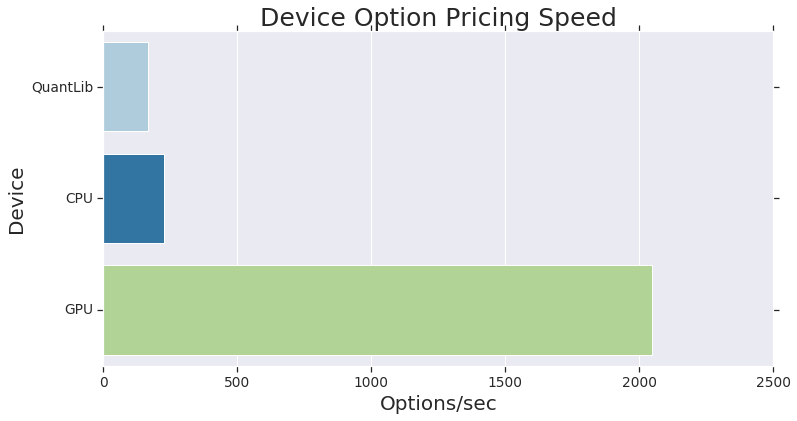

In [0]:
#@title Tensorflow Finance vs QuantLib
# Throughput
times_pd = pd.DataFrame([('QuantLib', number_of_options/29.93), 
                         ('CPU', number_of_options/time_cpu), 
                         ('GPU', number_of_options/time_gpu)],
                         columns=['Device', 'Options/sec'])
sns.set(style="darkgrid", palette="Paired")
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12, 6))
pt = sns.barplot(y="Device", x="Options/sec", data=times_pd)
pt.axes.set_title("Device Option Pricing Speed", fontsize=25)
xlabel = pt.axes.get_xlabel()
ylabel = pt.axes.get_ylabel()
pt.axes.set_xlabel(xlabel, fontsize=20)
pt.axes.set_ylabel(ylabel, fontsize=20)
plt.show()

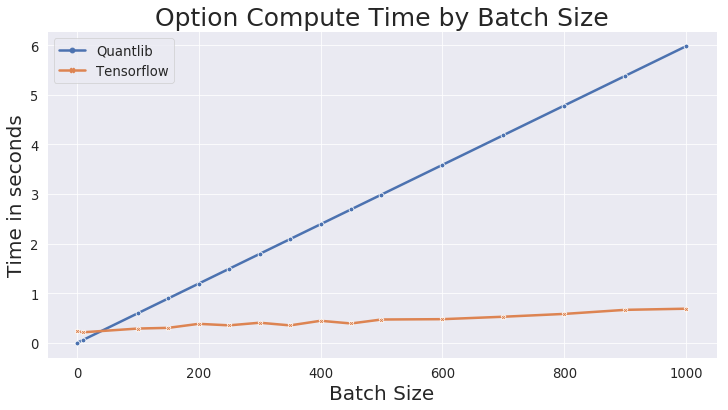

In [0]:
#@title Time to price a batch of options (GPU vs QuantLib)

import matplotlib.pyplot as plt
import numpy as np
import time
batch_of_options = [1, 10, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]  #@param

gpu_times = []
cpu_times = []


for options in batch_of_options:
  tf.reset_default_graph()
  # Generate volatilities, rates, strikes
  volatility, risk_free_rate, strike = option_param(number_of_options, dtype)
  with tf.device("/gpu:0"):
    estimate, _ = american_option(
        number_of_options=number_of_options,
        time_delta=time_delta,
        expiry=expiry,
        num_grid_points=number_grid_points,
        volatility=volatility,
        risk_free_rate=risk_free_rate,
        strike=strike,
        dtype=dtype)

  with tf.Session() as sess:
    sess.run(tf.constant([0]))  # warming-up

  with tf.Session() as sess:
    t = time.time()
    estimate = sess.run(estimate)
  time_gpu = time.time() - t
  gpu_times.append(time_gpu)

# We hardcode QunatLib values here for simplicity
ql_times = [29.9 / 5000 * i for i in batch_of_options]

# Prepare Plotting 
plt.figure(figsize=(12, 6))
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
#sns.set(rc={'figure.figsize':(14,10)})
batches = batch_of_options * 2
num_batches = len(batch_of_options)
method = ["Quantlib"] * num_batches +  ["Tensorflow"] * num_batches
times = ql_times + gpu_times
data = {"Batch Size": batches,
        "Method": method,
        "Times": times}
ql_gpu_times = pd.DataFrame(data = data)
plot = sns.lineplot(x="Batch Size", y="Times", hue="Method", style = "Method",
                    data=ql_gpu_times, markers=True, dashes=False, color=('darkorange',
                                                                          'royalblue'))
handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles[1:], labels=labels[1:], loc="upper left")
plot.axes.set_title("Option Compute Time by Batch Size",fontsize=25)
xlabel = plot.axes.get_xlabel()
plot.axes.set_xlabel(xlabel, fontsize=20)
plot.axes.set_ylabel('Time in seconds', fontsize=20)
plt.setp(plot.get_legend().get_title(), fontsize=28)
plt.show()

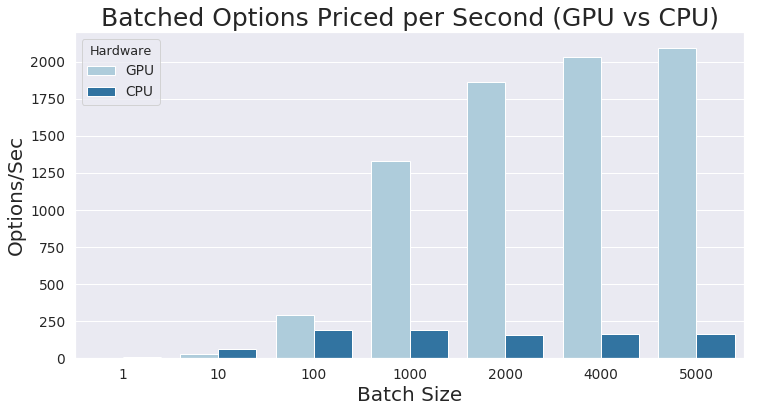

In [0]:
#@title Options per second depending on the batch size

batch_of_options = [1, 10, 100, 1000, 2000, 4000, 5000]  #@param
gpu_times = []
cpu_times = []

for options in batch_of_options:
  tf.reset_default_graph()
  with tf.device("/gpu:0"):
    # Generate volatilities, rates, strikes
    volatility, risk_free_rate, strike = option_param(number_of_options, dtype)
    estimate = american_option(
        number_of_options=number_of_options,
        time_delta=time_delta,
        expiry=expiry,
        num_grid_points=number_grid_points,
        volatility=volatility,
        risk_free_rate=risk_free_rate,
        strike=strike,
        dtype=dtype)

  with tf.Session() as sess:
    sess.run(tf.constant([0]))  # warming-up

  with tf.Session() as sess:
    t = time.time()
    estimate = sess.run(estimate)
  time_gpu = time.time() - t
  gpu_times.append(options / time_gpu)

for options in batch_of_options:
  tf.reset_default_graph()
  with tf.device("/cpu:0"):
    # Generate volatilities, rates, strikes
    volatility, risk_free_rate, strike = option_param(number_of_options, dtype)
    estimate = american_option(
        number_of_options=number_of_options,
        time_delta=time_delta,
        expiry=expiry,
        num_grid_points=number_grid_points,
        volatility=volatility,
        risk_free_rate=risk_free_rate,
        strike=strike,
        dtype=dtype)

  with tf.Session() as sess:
    sess.run(tf.constant([0]))  # warming-up

  with tf.Session() as sess:
    t = time.time()
    estimate = sess.run(estimate)
  time_cpu = time.time() - t
  cpu_times.append(options / time_cpu)

# Prepare data for plotting
plt.figure(figsize=(12, 6))
batches = batch_of_options * 2
num_batches = len(batch_of_options)
method = ["GPU"] * num_batches +  ["CPU"] * num_batches
times = gpu_times + cpu_times
data = {"Batch Size": batches,
        "Hardware": method,
        "Options/Sec": times}
gpu_cpu_times = pd.DataFrame(data = data)
sns.set(style="darkgrid", palette="Paired")
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
pt = sns.barplot(x="Batch Size", y="Options/Sec",hue="Hardware", data=gpu_cpu_times)
pt.axes.set_title("Batched Options Priced per Second (GPU vs CPU)",fontsize=25)
xlabel = pt.axes.get_xlabel()
ylabel = pt.axes.get_ylabel()
pt.axes.set_xlabel(xlabel, fontsize=20)
pt.axes.set_ylabel(ylabel, fontsize=20)
plt.show()